In [1]:
from DS_Planck_Unet import *
import numpy as np
from matplotlib import pyplot as plt
from DS_data_transformation import normalize
from DS_healpix_fragmentation import *

In [2]:
def clusters_in_pix(clusters, pix, nside):
    import pandas as pd
    import healpy as hp
    import numpy as np
    from DS_healpix_fragmentation import radec2pix
    
    df = pd.read_csv(clusters)
    cl_pix = radec2pix(df['RA'], df['DEC'], nside)
    df = df[cl_pix == pix]
    df.index = np.arange(df.shape[0])
    
    return df

In [8]:
def scan_pix(clusters, model, ipix, nside=2, depth=10, thr=0.8, min_dist=5/60, 
             step=64, size=64, n_false=None, search_nside=256):
    from DS_healpix_fragmentation import one_pixel_fragmentation, pix2radec, radec2pix
    from DS_Planck_Unet import draw_pic_with_mask
    from DS_detector import find_centers_on_ans
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import pandas as pd
    import numpy as np
    import healpy as hp
    from tensorflow.keras import backend as K
    from tqdm.notebook import tqdm
    
    big_matr = one_pixel_fragmentation(nside, ipix, depth)
    
    true_clusters = clusters_in_pix(clusters, ipix, nside)
    if n_false is None:
        n_false = 3 * len(true_clusters)
    
    pics, matrs = [], []
    
    for i in range(0, big_matr.shape[0] - step, step):
        for j in range(0, big_matr.shape[1], step):
            matr = big_matr[i:i+size,j:j+size]
            if matr.shape[0] == size and matr.shape[1] == size:
                pic = draw_pic(matr)
                pics.append(pic)
                matrs.append(matr)
    pics = np.array(pics)
    ans = model.predict(pics)
    ans = np.array(ans)
    found_clusters = find_centers_on_ans(ans, matrs, thr)
    all_found = len(found_clusters)
    theta, phi = hp.pix2ang(ipix=found_clusters, nest=True, nside=nside*2**depth,
                           lonlat=True)    
    sc_true = SkyCoord(ra=true_clusters['RA']*u.degree, 
                       dec=true_clusters['DEC']*u.degree, frame='icrs')
    sc_found = SkyCoord(l=theta*u.degree,
                       b=phi*u.degree, frame='galactic')
    
    idx, d2d, _ = sc_found.match_to_catalog_sky(sc_true)
    tp = np.count_nonzero(d2d.degree <= min_dist)
    fn = true_clusters.shape[0] - tp
    #----test false clusters----#
    pics, matrs = false_clusters(n_false, search_nside, '/home/rt2122/Data/clusters/',
                                [ipix])
    pics = np.array(pics)
    ans = model.predict(pics)
    ans = np.array(ans)
    found_clusters, tn = find_centers_on_ans(ans, matrs, thr, count_blank=True)
    fp = len(found_clusters)
    
    
    
    res_table = pd.DataFrame({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                              'all_found' : all_found,
                             'min_dist' : d2d.degree.min(), 'pix2' : ipix}, index=[0])
    return res_table


In [4]:
model = unet_planck(weights='/home/rt2122/Models/model.01-0.10.h5')

In [5]:
test_pix

[7]

In [9]:
res = scan_pix('/home/rt2122/Data/clusters/planck_z.csv', model, train_pix[0], thr=0.7)

In [10]:
res

,tp,fn,all_found,min_dist,pix2
0,5,15,169,0.008416,0


In [3]:
matr = one_pixel_fragmentation(2, 7, 10) 

In [4]:
2 * 2 ** 10

2048

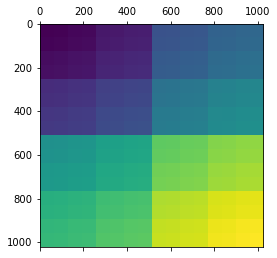

In [5]:
plt.matshow(matr)

In [6]:
pic = draw_pic(matr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


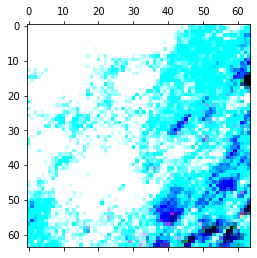

In [10]:
plt.matshow(pic[:64,:64,3:])

In [12]:
for i in range(0, matr.shape[0], 64):
    for j in range(0, matr.shape[1], 64):
        mmatr = matr[i:i+64,j:j+64]
        print(i, j, mmatr.shape)

0 0 (64, 64)
0 64 (64, 64)
0 128 (64, 64)
0 192 (64, 64)
0 256 (64, 64)
0 320 (64, 64)
0 384 (64, 64)
0 448 (64, 64)
0 512 (64, 64)
0 576 (64, 64)
0 640 (64, 64)
0 704 (64, 64)
0 768 (64, 64)
0 832 (64, 64)
0 896 (64, 64)
0 960 (64, 64)
64 0 (64, 64)
64 64 (64, 64)
64 128 (64, 64)
64 192 (64, 64)
64 256 (64, 64)
64 320 (64, 64)
64 384 (64, 64)
64 448 (64, 64)
64 512 (64, 64)
64 576 (64, 64)
64 640 (64, 64)
64 704 (64, 64)
64 768 (64, 64)
64 832 (64, 64)
64 896 (64, 64)
64 960 (64, 64)
128 0 (64, 64)
128 64 (64, 64)
128 128 (64, 64)
128 192 (64, 64)
128 256 (64, 64)
128 320 (64, 64)
128 384 (64, 64)
128 448 (64, 64)
128 512 (64, 64)
128 576 (64, 64)
128 640 (64, 64)
128 704 (64, 64)
128 768 (64, 64)
128 832 (64, 64)
128 896 (64, 64)
128 960 (64, 64)
192 0 (64, 64)
192 64 (64, 64)
192 128 (64, 64)
192 192 (64, 64)
192 256 (64, 64)
192 320 (64, 64)
192 384 (64, 64)
192 448 (64, 64)
192 512 (64, 64)
192 576 (64, 64)
192 640 (64, 64)
192 704 (64, 64)
192 768 (64, 64)
192 832 (64, 64)
192 89

In [18]:
res

,tp,fn,all_found,min_dist,pix2
0,0,20,511,58.222806,0


In [6]:
test_gen = gen_data('/home/rt2122/Data/clusters/planck_z.csv', test_pix, 1, 
                   search_nside=256, min_rad=0.08)

(1, 64, 64, 6) (1, 64, 64, 1)


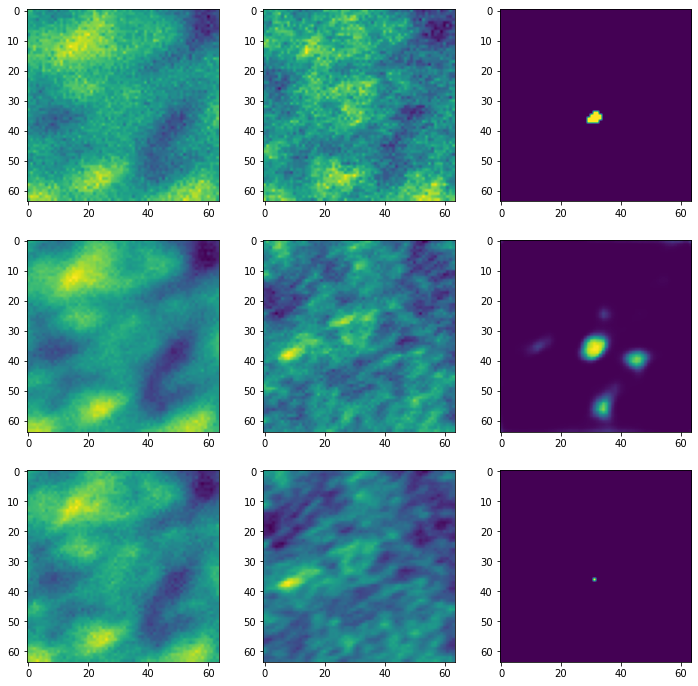

In [7]:
check_gen(test_gen, model)

In [8]:
a = np.arange(16).reshape((4, 4))
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [18]:
x = [0, 1, 0]
y = [3, 3, 2]
a[[x, y]]

<ipython-input-18-e96045714c5b>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[x, y]]


array([3, 7, 2])

In [13]:
a[[1, 2]]

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [11]:
res1 = scan_pix('/home/rt2122/Data/clusters/planck_z.csv', model, test_pix[0], thr=0.7)

/home/rt2122/L/git/data-segmentation-2/modules/DS_detector.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  centers.extend(list(matrs[i][[new_cen[:, 0], new_cen[:, 1]]]))


In [12]:
res1

,tp,fn,all_found,min_dist,pix2
0,17,25,280,0.007522,7
